In [1]:
versioninfo()

Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 32 × Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, haswell)
  Threads: 2 on 32 virtual cores
Environment:
  JULIA_PKG_SERVER = https://mirrors.tuna.tsinghua.edu.cn/julia


In [27]:
# set the output format of gr backend to png while the default is svg, which disappears in jupyter pages (after restart).
# StatsPlots has an identical gr() function.
@time using Plots;
#gr(fmt = "png")
@time gr(fmt = :png)

#@time using StatsPlots; 
#@time gr(fmt = :png)

  0.001230 seconds (140 allocations: 13.141 KiB)
  0.000062 seconds (5 allocations: 576 bytes)


Plots.GRBackend()

In [3]:
using Random
using StatsBase
using Distributions
using StatsPlots
using StatsFuns
using Logging

using Turing
using CSV
using DataFrames
using Optim
#using StatisticalRethinking

default(labels=false)
Logging.disable_logging(Logging.Warn);

# 9.1 Good King Markov and his 10-island kingdom

## Code 9.1

In [83]:
Random.seed!(1)
num_weeks = 10^5
positions = []
current = 2

for i ∈ 1:num_weeks
    # record current position
    push!(positions, current)
    # flip coin to generate proposal
    proposal = current + sample([-1, 1])
    # handle loops around
    proposal < 1 && (proposal = 10)
    proposal > 10 && (proposal = 1)
    # move?
    prob_move = proposal / current
    rand() < prob_move && (current = proposal)
end

## Code 9.2 Figure 9.2

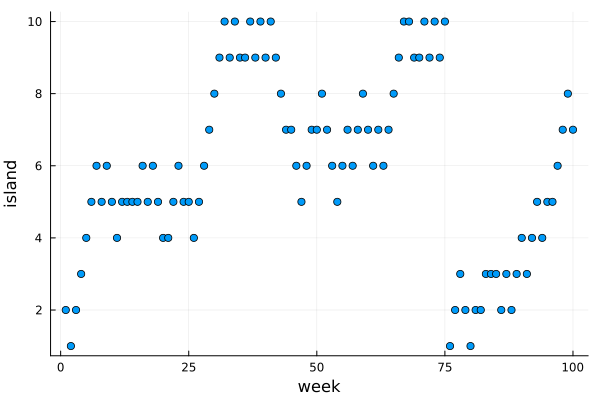

In [84]:
scatter(positions[1:100], xlab="week", ylab="island")

## Code 9.3

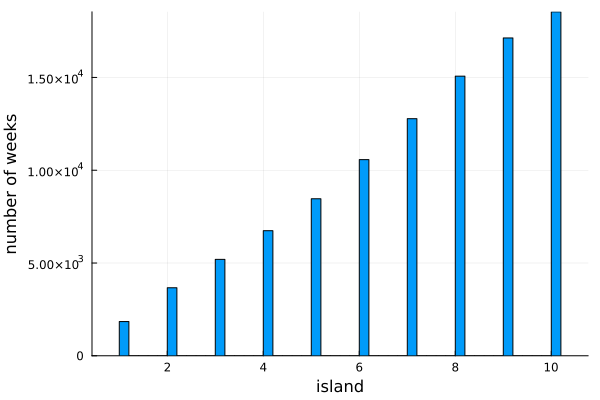

In [85]:
histogram(positions, xlab="island", ylab="number of weeks")

# 9.2 Metropolis algorithms

## Code 9.4 Curse of dimensionality in MV-Normal

In [79]:
function draw_MVNormal_density_concentration(; D=10, T=1000)
    # D is #dimensions.
    # T is #samples.
    #for D in [1,10,100,1000]        
    # Normal mean at 0, stddev=1.
    @time Y = rand(MvNormal(zeros(D), ones(D)), T)
    @time Rd = sqrt.(sum.(eachcol(Y.^2)))
    plot(density(Rd), xlim = (-1, 20))
    xlabel!("Distance to the center")
    ylabel!("Density")
end

draw_MVNormal_density_concentration (generic function with 3 methods)

  0.000033 seconds (4 allocations: 8.125 KiB)
  0.000011 seconds (2 allocations: 15.875 KiB)


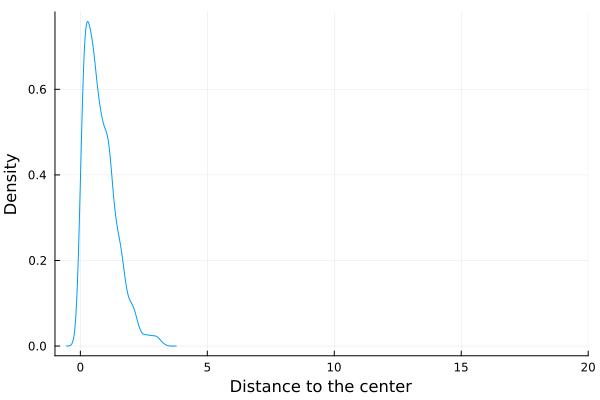

In [80]:
draw_MVNormal_density_concentration(D=1, T=1000)

  0.000192 seconds (5 allocations: 78.594 KiB)
  0.000061 seconds (3 allocations: 86.109 KiB)


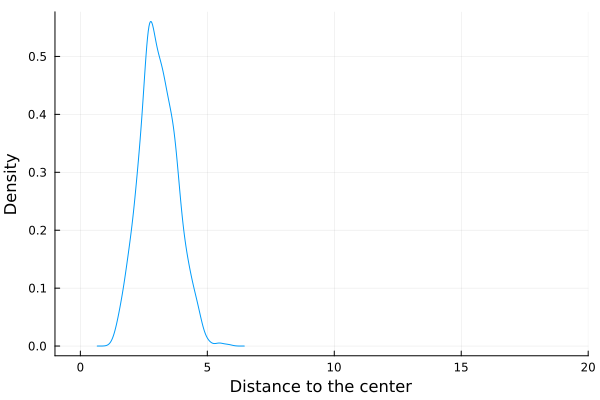

In [81]:
draw_MVNormal_density_concentration(D=10, T=1000)

  0.001614 seconds (5 allocations: 783.922 KiB)
  0.000314 seconds (3 allocations: 789.234 KiB)


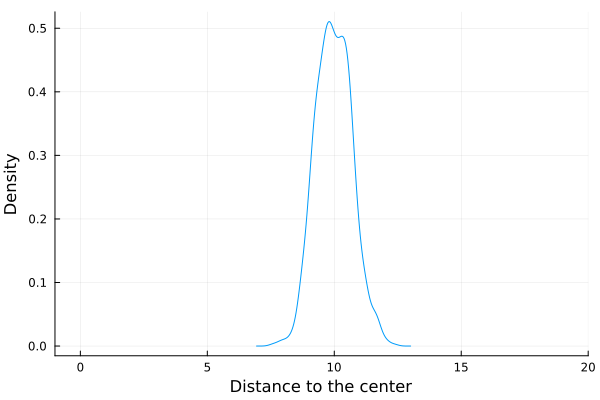

In [82]:
draw_MVNormal_density_concentration(D=100, T=1000)

In [57]:
@show size(Y)

size(Y) = (10, 1000)


(10, 1000)

In [62]:
@time sqrt.(sum.(eachcol(Y.^2)))

  0.000143 seconds (12 allocations: 86.344 KiB)


1000-element Vector{Float64}:
 2.3205501628370313
 2.9367159498263833
 2.8933925526123465
 2.8825136938952403
 2.884735040883977
 2.4198355576288098
 2.658354040347115
 2.673912991788573
 3.482502386274858
 3.778928222748504
 3.7272856414800195
 3.1145765601600615
 3.6062399600646065
 ⋮
 4.04602461761879
 2.1856347655158834
 3.1962901686192495
 3.1692535374001953
 1.077095246882365
 3.6600936609673544
 2.729160683263009
 2.223385695541407
 3.43060336504033
 3.2613100234079275
 3.0140594489765435
 2.9897851357977627

# 9.3 Hamiltonian Monte Carlo

## Code 9.5

In [34]:
Random.seed!(7)

x = rand(Normal(), 50)
y = rand(Normal(), 50)
x = standardize(ZScoreTransform, x)
y = standardize(ZScoreTransform, y);

- -log(likelihood * prior): negative log-probability of data given parameters

In [35]:
function U(q::Vector{Float64}; a=0, b=1, k=0, d=1)::Float64
    μy, μx = q
    U = sum(normlogpdf.(μy, 1, y)) + sum(normlogpdf.(μx, 1, x)) 
    U += normlogpdf(a, b, μy) + normlogpdf(k, d, μx)
    -U
end

U (generic function with 1 method)

## Code 9.6 Gradient $\Delta U$

In [36]:
function ∇U(q::Vector{Float64}; a=0, b=1, k=0, d=1)::Vector{Float64}
    μy, μx = q
    G₁ = sum(y .- μy) + (a - μy) / b^2  # ∂U/∂μy
    G₂ = sum(x .- μx) + (k - μx) / d^2  # ∂U/∂μx
    [-G₁, -G₂]
end

∇U (generic function with 1 method)

## Code 9.8, 9.9, 9.10 (before 9.7 to define HMC2 funcition)

In [37]:
function HMC2(U, ∇U, ϵ::Float64, L::Int, current_q::Vector{Float64})
    q = current_q
    p = rand(Normal(), length(q))  # random flick - p is momentum
    current_p = p
    
    # make a half step for momentum at the beginning
    p -= ϵ .* ∇U(q) ./ 2
    
    # initialize bookkeeping - saves trajectory
    qtraj = [q]
    ptraj = [p]
    
    # Alternate full steps for position and momentum
    for i ∈ 1:L
        q += @. ϵ * p  # full step for the position
        # make a full step for the momentum except at the end of trajectory
        if i != L
            p -= ϵ * ∇U(q)
            push!(ptraj, p)
        end
        push!(qtraj, q)
    end
    
    # Make a half step for momentum at the end
    p -= ϵ * ∇U(q) / 2
    push!(ptraj, p)
    
    # negate momentum at the end of trajectory to make the proposal symmetric
    p = -p
    
    # evaluate potential and kinetic energies at the start and the end of trajectory
    current_U = U(current_q)
    current_K = sum(current_p.^2)/2
    proposed_U = U(q)
    proposed_K = sum(p.^2)/2
    
    # accept or reject the state at the end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    accept = (rand() < exp(current_U - proposed_U + current_K - proposed_K))

    if accept
        current_q = q
    end
    
    (q=current_q, traj=qtraj, ptraj=ptraj, accept=accept)
end

HMC2 (generic function with 1 method)

## Code 9.7

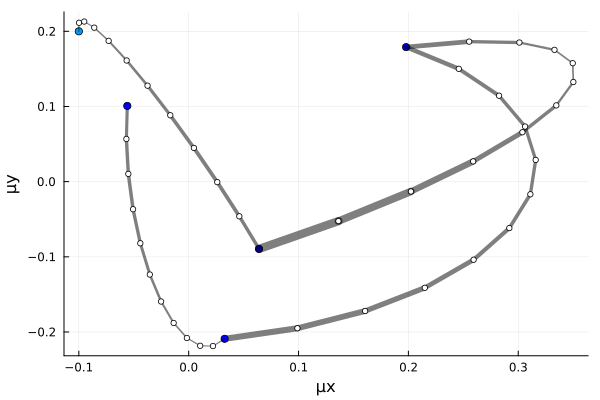

In [38]:
Random.seed!(1)
Q = (q=[-0.1, 0.2],)
# pr is un-used?
pr = 0.3
# step size
step = 0.03
# number of leapfrogs
L = 11
n_samples = 4
p = scatter([Q.q[1]], [Q.q[2]], xlab="μx", ylab="μy")

for i ∈ 1:n_samples
    Q = HMC2(U, ∇U, step, L, Q.q)
    if n_samples < 10 
        cx, cy = [], []
        for j ∈ 1:L
            K0 = sum(Q.ptraj[j].^2)/2
            plot!(
                [Q.traj[j][1], Q.traj[j+1][1]],
                [Q.traj[j][2], Q.traj[j+1][2]],
                lw=1+2*K0,
                c=:black,
                alpha=0.5
            )
            push!(cx, Q.traj[j+1][1])
            push!(cy, Q.traj[j+1][2])
        end
        scatter!(cx, cy, c=:white, ms=3)
    end
    scatter!([Q.q[1]], [Q.q[2]], shape=(Q.accept ? :circle : :rect), c=:blue)
end
p

# 9.4 Easy HMC: ulam

## Code 9.11

In [39]:
d = DataFrame(CSV.File("data/rugged.csv"))
dd = d[completecases(d, :rgdppc_2000),:]
dd[:,:log_gdp] = log.(dd.rgdppc_2000);
dd[:,:log_gdp_std] = dd.log_gdp / mean(dd.log_gdp)
dd[:,:rugged_std] = dd.rugged / maximum(dd.rugged)
dd[:,:cid] = @. ifelse(dd.cont_africa == 1, 1, 2);

## Code 9.12

In [40]:
r̄ = mean(dd.rugged_std);

@model function model_m8_3(rugged_std, cid,  log_gdp_std)
    σ ~ Exponential()
    a ~ MvNormal([1, 1], 0.1)
    b ~ MvNormal([0, 0], 0.3)
    μ = @. a[cid] + b[cid] * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

m8_3 = optimize(model_m8_3(dd.rugged_std, dd.cid,  dd.log_gdp_std), MAP())
m8_3_df = DataFrame(sample(m8_3, 1000))
precis(m8_3_df)

LoadError: MethodError: no method matching sample(::TuringOptimExt.ModeResult{NamedArrays.NamedVector{Float64, Vector{Float64}, Tuple{OrderedCollections.OrderedDict{Symbol, Int64}}}, Optim.MultivariateOptimizationResults{LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}, Vector{Float64}, Float64, Float64, Vector{OptimizationState{Float64, LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}}}, Bool, NamedTuple{(:f_limit_reached, :g_limit_reached, :h_limit_reached, :time_limit, :callback, :f_increased), NTuple{6, Bool}}}, LogDensityFunction{DynamicPPL.TypedVarInfo{NamedTuple{(:σ, :a, :b), Tuple{DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:σ, Setfield.IdentityLens}, Int64}, Vector{Exponential{Float64}}, Vector{AbstractPPL.VarName{:σ, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:a, Setfield.IdentityLens}, Int64}, Vector{IsoNormal}, Vector{AbstractPPL.VarName{:a, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b, Setfield.IdentityLens}, Int64}, Vector{IsoNormal}, Vector{AbstractPPL.VarName{:b, Setfield.IdentityLens}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}}}, Float64}, DynamicPPL.Model{typeof(model_m8_3), (:rugged_std, :cid, :log_gdp_std), (), (), Tuple{Vector{Float64}, Vector{Int64}, Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext}, Turing.Optimisation.OptimizationContext{DynamicPPL.DefaultContext}}}, ::Int64)

[0mClosest candidates are:
[0m  sample([91m::AbstractRNG[39m, ::Any, [91m::AbstractMCMC.AbstractSampler[39m, [91m::AbstractMCMC.AbstractMCMCEnsemble[39m, [91m::Integer[39m, [91m::Integer[39m; kwargs...)
[0m[90m   @[39m [35mAbstractMCMC[39m [90m~/.julia/packages/AbstractMCMC/fWWW0/src/[39m[90m[4mlogdensityproblems.jl:64[24m[39m
[0m  sample([91m::AbstractRNG[39m, ::Any, [91m::AbstractMCMC.AbstractSampler[39m, [91m::Any[39m; kwargs...)
[0m[90m   @[39m [35mAbstractMCMC[39m [90m~/.julia/packages/AbstractMCMC/fWWW0/src/[39m[90m[4mlogdensityproblems.jl:43[24m[39m
[0m  sample([91m::Chains[39m, ::Integer; replace, ordered)
[0m[90m   @[39m [36mMCMCChains[39m [90m~/.julia/packages/MCMCChains/OVsxE/src/[39m[90m[4msampling.jl:19[24m[39m
[0m  ...


## Code 9.13

For Turing this is not needed

In [15]:
dat_slim = dd[!,[:log_gdp_std, :rugged_std, :cid]]
describe(dat_slim)

3×7 DataFrame
 Row │ variable     mean     min          median    max      nmissing  eltype  ⋯
     │ Symbol       Float64  Real         Float64   Real     Int64     DataTyp ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ log_gdp_std  1.0      0.721556     1.00718   1.28736         0  Float64 ⋯
   2 │ rugged_std   0.21496  0.000483715  0.157933  1.0             0  Float64
   3 │ cid          1.71176  1            2.0       2               0  Int64
                                                                1 column omitted

## Code 9.14

In [16]:
@model function model_m9_1(rugged_std, cid,  log_gdp_std)
    σ ~ Exponential()
    a ~ MvNormal([1, 1], 0.1)
    b ~ MvNormal([0, 0], 0.3)
    μ = @. a[cid] + b[cid] * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

# one chain will be produced by default
m9_1 = sample(model_m8_3(dd.rugged_std, dd.cid,  dd.log_gdp_std), NUTS(), 1000);

## Code 9.15

In [15]:
precis(DataFrame(m9_1))

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│  a[1] │  0.8865  0.0157   0.8606   0.8863    0.911    ▁▁▂▃▇██▅▂▁▁ │
│  a[2] │  1.0509  0.0097   1.0353   1.0512   1.0662  ▁▁▂▄▆██▆▅▂▁▁▁ │
│  b[1] │  0.1299  0.0708   0.0168   0.1311   0.2381    ▁▁▂▃▇██▄▁▁▁ │
│  b[2] │ -0.1424  0.0557  -0.2309  -0.1428  -0.0524      ▁▁▃██▅▂▁▁ │
│     σ │  0.1117  0.0066    0.102   0.1114   0.1227     ▁▁▄▇█▅▃▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


## Code 9.16

For this to use multiple cores, julia has to be started with `--threads 4` parameter, otherwise chains will be sampled sequentially

In [41]:
@time m9_1 = sample(model_m8_3(dd.rugged_std, dd.cid,  dd.log_gdp_std), NUTS(), MCMCThreads(), 250, 4);

  3.332678 seconds (3.43 M allocations: 1019.032 MiB, 6.98% gc time, 69.60% compilation time: 100% of which was recompilation)


## Code 9.17

This shows combined chains statistics. To get information about individual chains, use `m9_1[:,:,1]`

In [18]:
m9_1

Chains MCMC chain (250×17×4 Array{Float64, 3}):

Iterations        = 126:1:375
Number of chains  = 4
Samples per chain = 250
Wall duration     = 1.83 seconds
Compute duration  = 1.44 seconds
parameters        = σ, a[1], a[2], b[1], b[2]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           σ    0.1117    0.0060    0.0002   841.8968   537.9230    1.0047     ⋯
        a[1]    0.8863    0.0161    0.0005   999.5038   749.4195    1.0003     ⋯
        a[2]    1.0505    0.0107    0.0003   998.9248   835.1413    1.0016     ⋯
        b[1]    0.1303    0.0799    0.0034   538.8104   424.8667    1.0025     ⋯
        b[2]   -0.1434    0.0560    0.0020   773.361

## Code 9.18

In [19]:
precis(DataFrame(m9_1[:,:,1:2]))

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│  a[1] │  0.8857  0.0161    0.862   0.8849    0.913     ▁▁▁▄██▇▄▃▁▁ │
│  a[2] │  1.0504  0.0107   1.0337   1.0505   1.0684  ▁▁▂▃▅▇█▅▃▂▁▁▁▁ │
│  b[1] │  0.1338    0.08   0.0125   0.1333   0.2729   ▁▁▁▄▆█▆▄▃▁▁▁▁ │
│  b[2] │ -0.1458  0.0555  -0.2297  -0.1472  -0.0551         ▁▁▄██▅▂ │
│     σ │  0.1116  0.0057   0.1026   0.1116   0.1203       ▁▃▇█▅▂▁▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


## Code 9.19

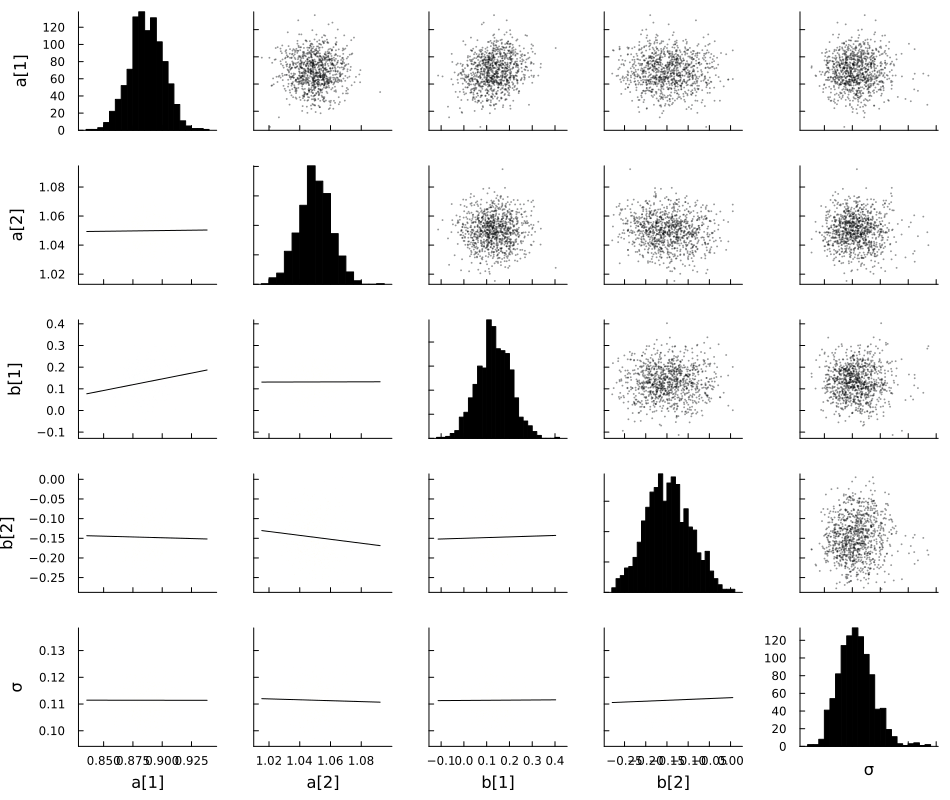

In [42]:
@df DataFrame(m9_1) corrplot(cols(1:5), seriestype=:scatter, ms=0.2, size=(950, 800), bins=30, grid=false)

## Code 9.20

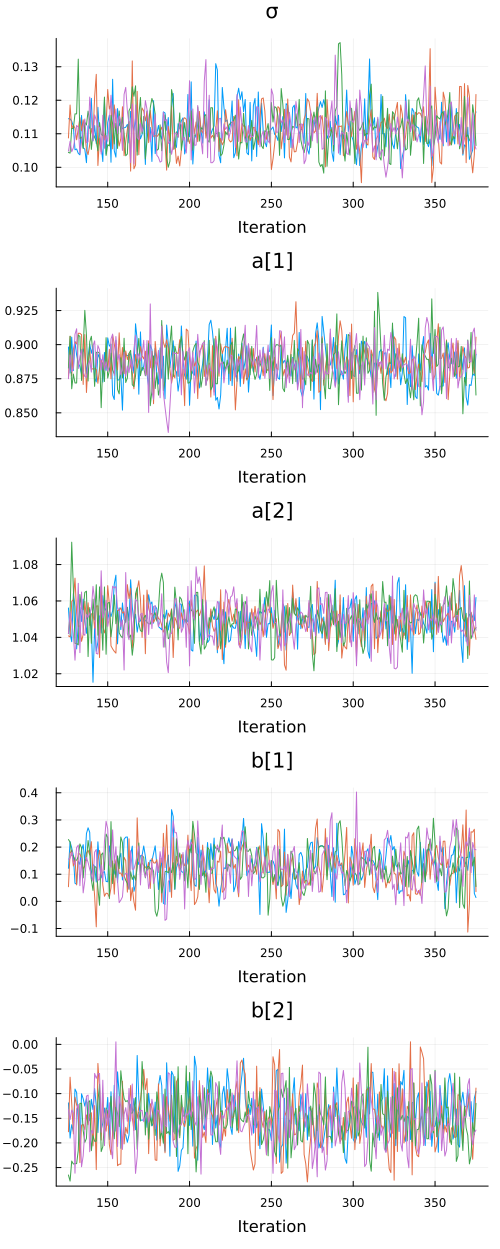

In [43]:
traceplot(m9_1)

## Code 9.21

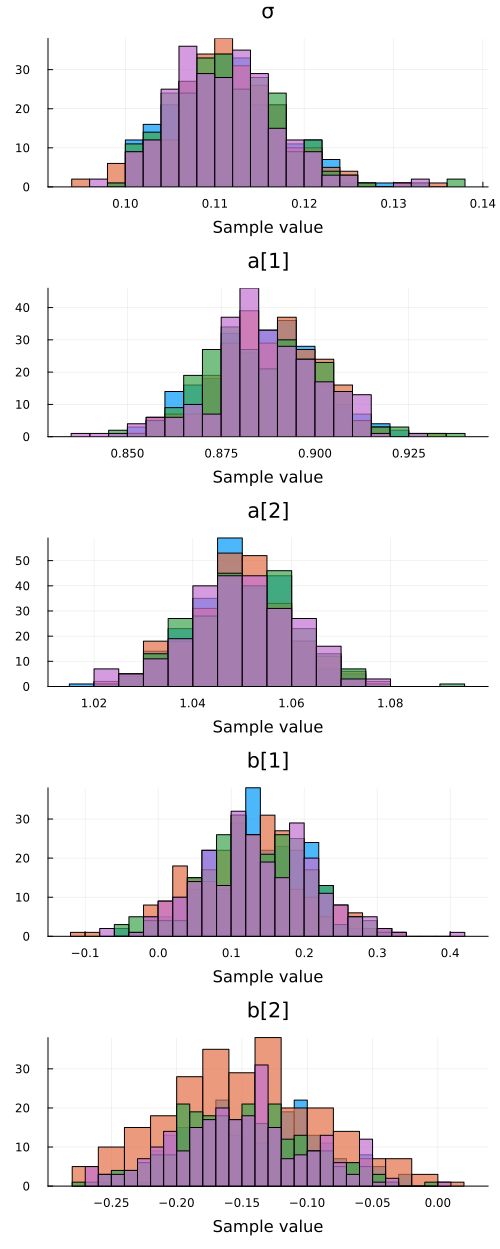

In [44]:
histogram(m9_1)

# 9.5 Care and feeding of your Markov chain

## Code 9.22

To make it diverging with Turing, was needed to increase exp() argument.

In [47]:
Random.seed!(1)
y = [-1., 1.]

@model function model_m9_2(y)
    α ~ Normal(0, 1000)
    σ ~ Exponential(1/0.0001)
    y ~ Normal(α, σ)
end

@time m9_2 = sample(model_m9_2(y), NUTS(), 1000)
@time m9_2_df = DataFrame(m9_2);

  2.446970 seconds (2.61 M allocations: 201.511 MiB, 3.84% gc time, 86.95% compilation time: 83% of which was recompilation)
  0.000075 seconds (71 allocations: 36.297 KiB)


## Code 9.23

In [24]:
precis(m9_2_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean      std      5.5%      50%    94.5%  histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     α │ -7.0075  290.117  -535.734  -0.1893  429.386   ▁▁▁██▁▁▁ │
│     σ │ 526.252  1296.11   10.1492  76.6043   2401.1  █▁▁▁▁▁▁▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


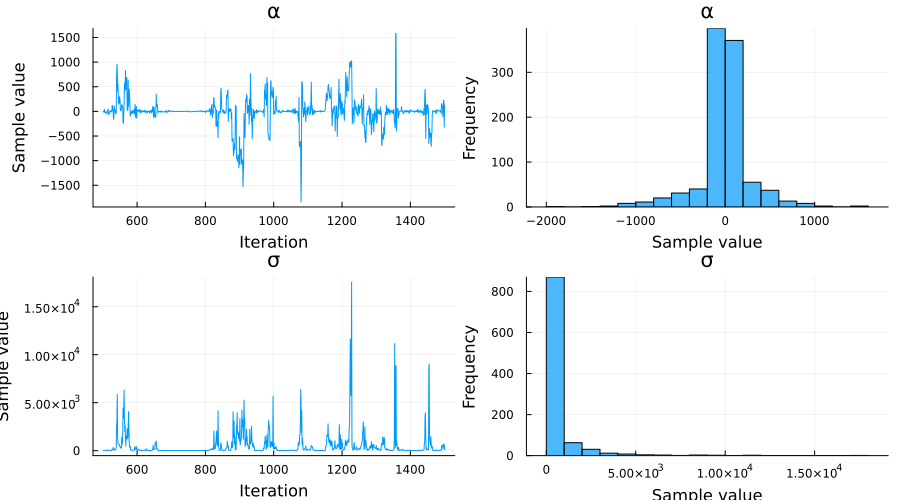

In [48]:
plot(
    traceplot(m9_2),
    histogram(m9_2),
    size=(900, 500)
)

## Code 9.24

In [44]:
Random.seed!(2)

@model function model_m9_3(y)
    α ~ Normal(1, 10)
    σ ~ Exponential(1)
    y ~ Normal(α, σ)
end

m9_3 = sample(model_m9_3(y), NUTS(), 1000)
m9_3_df = DataFrame(m9_3)
precis(m9_3_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%     50%   94.5%      histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     α │ -0.0271  1.2576  -1.9354  0.0051  1.9253   ▁▁▁▁▃██▂▁▁▁▁ │
│     σ │  1.5607  0.8481   0.6739  1.3216  3.1969  ▁██▅▃▂▂▁▁▁▁▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


## Code 9.25

In [45]:
Random.seed!(41)
y = rand(Normal(), 100);

## Code 9.26

In [49]:
Random.seed!(384)

@model function model_m9_4(y)
    a1 ~ Normal(0, 1000)
    a2 ~ Normal(0, 1000)
    σ ~ Exponential(1)
    μ = a1 + a2
    y ~ Normal(μ, σ)
end

@time m9_4 = sample(model_m9_4(y), NUTS(), 1000)
m9_4_df = DataFrame(m9_4)
display(precis(m9_4_df))
ess_rhat(m9_4)

 12.081381 seconds (19.51 M allocations: 1.622 GiB, 8.94% gc time, 84.05% compilation time)
┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean      std      5.5%       50%     94.5%  histogram │
├───────┼───────────────────────────────────────────────────────────┤
│    a1 │ 171.594  10.6275   154.872   170.063    186.71  ▂▆▃█▄▄█▃▁ │
│    a2 │ -171.59  10.6034  -186.724  -169.953  -155.255  ▁▃█▄▃█▃▆▂ │
│     σ │  0.9169    0.011    0.9014    0.9163    0.9336  ▂█▆▅█▄▇▇▁ │
└───────┴───────────────────────────────────────────────────────────┘


nothing

ESS/R-hat
  parameters       ess      rhat   ess_per_sec 
      Symbol   Float64   Float64       Float64 

          a1    2.8797    1.6483        0.3162
          a2    2.8931    1.6400        0.3176
           σ    2.5009    2.0444        0.2746


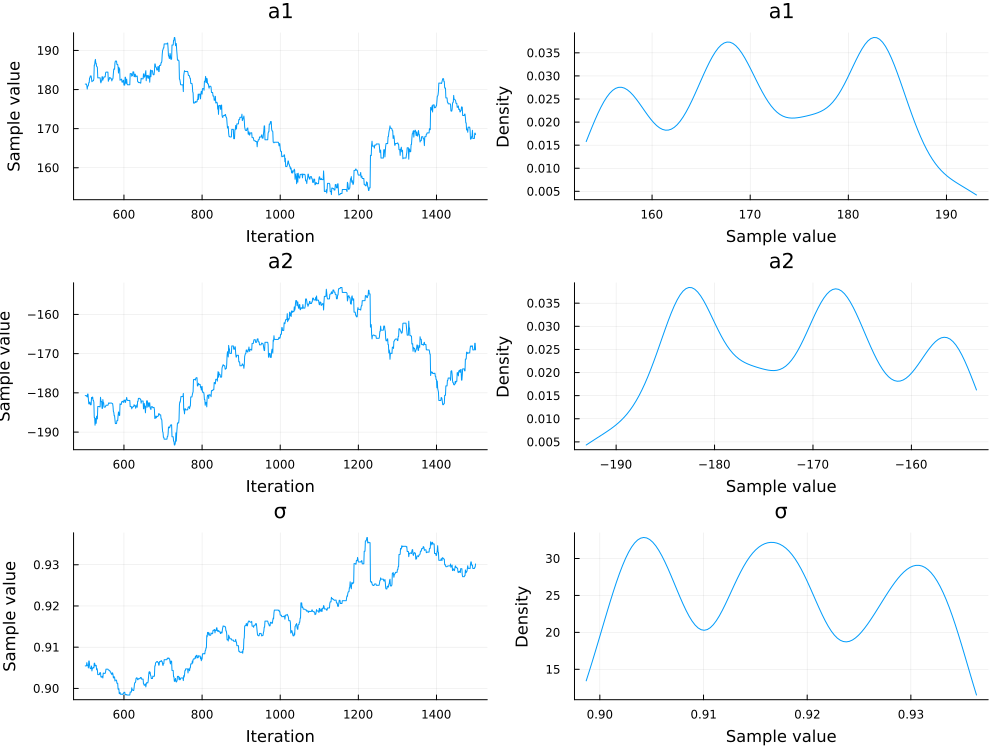

In [50]:
plot(m9_4)

## Code 9.27

In [53]:
Random.seed!(384)

@model function model_m9_5(y)
    a1 ~ Normal(0, 10)
    a2 ~ Normal(0, 10)
    σ ~ Exponential(1)
    μ = a1 + a2
    y ~ Normal(μ, σ)
end

@time m9_5 = sample(model_m9_5(y), NUTS(), 1000)
m9_5_df = DataFrame(m9_5)
display(precis(m9_5_df))
ess_rhat(m9_5)

  2.797526 seconds (3.15 M allocations: 279.739 MiB, 5.31% gc time, 82.01% compilation time: 84% of which was recompilation)
┌───────┬───────────────────────────────────────────────────────┐
│ param │   mean     std      5.5%      50%    94.5%  histogram │
├───────┼───────────────────────────────────────────────────────┤
│    a1 │ -0.889  7.3615  -13.2932  -0.6542  11.0716  ▁▄▆██▅▂▁▁ │
│    a2 │  0.873  7.3468  -11.1467   0.6142  13.1903   ▁▂▅██▅▄▁ │
│     σ │ 1.5523  0.9584    0.6069   1.2865   3.3538  ▇█▄▁▁▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────┘


nothing

ESS/R-hat
  parameters       ess      rhat   ess_per_sec 
      Symbol   Float64   Float64       Float64 

          a1   88.6145    1.0019       48.1863
          a2   90.0207    1.0027       48.9509
           σ   50.2621    1.0129       27.3312


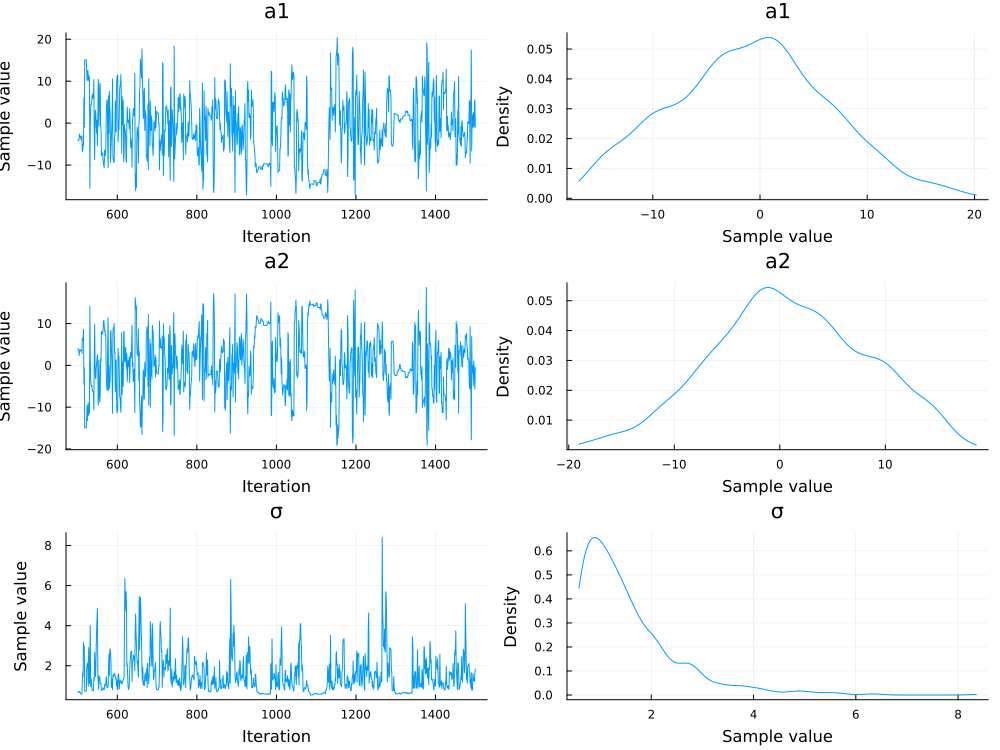

In [52]:
plot(m9_5)